<a href="https://colab.research.google.com/github/miguel-rg/learning_addition/blob/main/learning_to_sum_binary_numbers_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook reproduces the main results contained in "Model architecture can transform catastrophic forgetting into positive transfer" by Miguel Ruiz-García

In [1]:
import jax
from jax import numpy as jnp
import numpy as np
from jax import grad, jit
from jax.tree_util import tree_multimap
import matplotlib.pyplot as plt
import time 

import seaborn as sns
fontsize=20
sns.set(context='talk', font_scale=1,  color_codes=True,  style='ticks', # palette='deep',
            rc={"font.size":fontsize,"axes.titlesize":fontsize,"axes.labelsize":fontsize, 'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 1.0})
  

Some parameters

In [2]:
# dimension of the binary numbers
dim = 5

# number of pairs in the test data set
size_test_dataset = 100

# plotting intermediate figures
plotting_intermediate_figures = False

Some definitions

In [3]:
# U operator used in the correct binary sum (see Fig. 1 of the paper)
U = [ [[np.array([0,0]),np.array([1,0])],[np.array([1,0]),np.array([0,1])]] , [[np.array([1,0]),np.array([0,1])],[np.array([0,1]),np.array([1,1])]] ] 
U = jnp.array(U)
real_params = [0,0,1,0,1,0,0,1,1,0,0,1,0,1,1,1]
ones_pos = np.where(np.array(real_params) == 1)[0]
zeros_pos = np.where(np.array(real_params) == 0)[0]

In [4]:

# function to convert numbers from binary to decimal form
def bin_to_dec(bn):
  s=0
  for iii in range(len(bn)):
    s += bn[-1-iii]*2**iii
  return s

# function that computes the binary addition
@jit
def correct_bin_sum(n1,n2):
  n4 = jnp.zeros(dim+1)
  n3=0
  for iii in range(len(n1)):
    index = -1-iii
    n4_i, n3 = U[n3][n1[index]][n2[index]]
    n4 = n4.at[index].set(n4_i)
  n4 = n4.at[0].set(n3)
  return n4
  
@jit
def sigmoid(x):
  return 1 / (1 + jnp.exp(-x))


#  testing our funtion
n1 = np.random.rand(dim)
n1 = np.round(n1)
n1 = n1.astype(int)

n2 = np.random.rand(dim)
n2 = np.round(n2)
n2 = n2.astype(int)

print(bin_to_dec(n1),'+',bin_to_dec(n2),'=',bin_to_dec(correct_bin_sum(n1,n2)))

# function to convert numbers from decimal to binary form
def dec_to_bin(n):
  zzz = np.zeros(dim)
  nnn = [int(aaa) for aaa in list("{0:b}".format(n))]
  for iii in range(len(nnn)):
    zzz[-1-iii]=nnn[-1-iii]
  return jnp.array([zzz.astype(int)])

10 + 0 = 10.0


In [5]:

# U operator that contains the parameters that will have to be learnt (this is our customized NN)
@jit
def Uparams(params):
  return jnp.array([ [[[sigmoid(params[0]),sigmoid(params[1])],[sigmoid(params[2]),sigmoid(params[3])]],[[sigmoid(params[4]),sigmoid(params[5])],[sigmoid(params[6]),sigmoid(params[7])]]] , [[[sigmoid(params[8]),sigmoid(params[9])],[sigmoid(params[10]),sigmoid(params[11])]],[[sigmoid(params[12]),sigmoid(params[13])],[sigmoid(params[14]),sigmoid(params[15])]]] ] )


# binary sum using the NN (U with parameters), see Fig. 1 of the paper.
@jit
def NN_bin_sum(params,n1,n2):

  ### SUM USING Up ###
  Up = Uparams(params)
  n3 = 0
  n4 = jnp.zeros(dim+1)
  for iii in range(len(n1)):
    index = -1-iii
    
    n4_i = n3*Up[1][n1[index]][n2[index]][0] + (1-n3)*Up[0][n1[index]][n2[index]][0]
    n3 = n3*Up[1][n1[index]][n2[index]][1] + (1-n3)*Up[0][n1[index]][n2[index]][1]

    n4 = n4.at[index].set(n4_i)
  n4 = n4.at[0].set(n3)

  return n4

# loss function for the sum of a pair of numbers
@jit
def loss(params,n1,n2):
  n4 = NN_bin_sum(params,n1,n2)
  return jnp.sum(jnp.square(n4-correct_bin_sum(n1,n2)))


# creating the ones and twos addition facts
test_dataset_1 = []
test_dataset_2 = []
for iii in range(size_test_dataset):
  n1 = np.random.rand(dim)
  n1 = np.round(n1)
  test_dataset_1 += jnp.array([n1.astype(int)])
  n1 = np.random.rand(dim)
  n1 = np.round(n1)
  test_dataset_2 += jnp.array([n1.astype(int)])


## ONES ADDITION FACTS
ones_add_facts_1 = []
ones_add_facts_2 = []
for iii in range(9):
  ones_add_facts_1 += dec_to_bin(1)
  ones_add_facts_2 += dec_to_bin(1+iii)
for iii in range(9):
  ones_add_facts_1 += dec_to_bin(1+iii)
  ones_add_facts_2 += dec_to_bin(1)


## TWOS ADDITION FACTS
twos_add_facts_1 = []
twos_add_facts_2 = []
for iii in range(9):
  twos_add_facts_1 += dec_to_bin(2)
  twos_add_facts_2 += dec_to_bin(1+iii)
for iii in range(9):
  twos_add_facts_1 += dec_to_bin(1+iii)
  twos_add_facts_2 += dec_to_bin(2)

# loss function when considering more than one pair of numbers
@jit
def loss_add_facts(params_1,test_dataset_1,test_dataset_2):
  loss_sum = 0
  for ind in range(len(test_dataset_1)):
    loss_sum += loss(params_1,test_dataset_1[ind],test_dataset_2[ind])
  ave_loss = loss_sum/len(test_dataset_1)
  return ave_loss


# test loss for the case where we train on one example at a time 
@jit
def test_loss(params_1,test_dataset_1,test_dataset_2):
  loss_sum = 0
  for ind in range(size_test_dataset):
    loss_sum += loss(params_1,test_dataset_1[ind],test_dataset_2[ind])
  ave_loss = loss_sum/size_test_dataset
  return ave_loss


## Learning addition with the conditions proposed by McCloskey and Cohen  

A recent update in JAX has made the compilation of the functions extremely slow in this case, the first iteration may take around 8 minutes. This can be improved, however we have kept the present version for explanatory purposes. 

In [6]:
 

learning_rate = 1
steps_print = 100
total_time_per_group = 2000

np.random.seed(1)
params = np.random.uniform(-1,1,size=16) 
params = jnp.array(params)

losses_ones = []
losses_twos = []
params_save = []

time_old = time.time()


for add_f_ind in range(2):

  if add_f_ind == 0:
    group_1 = ones_add_facts_1
    group_2 = ones_add_facts_2
  elif add_f_ind == 1:
    group_1 = twos_add_facts_1
    group_2 = twos_add_facts_2

  for t in range(total_time_per_group):
    
    loss_ones = loss_add_facts(params,ones_add_facts_1,ones_add_facts_2)
    loss_twos = loss_add_facts(params,twos_add_facts_1,twos_add_facts_2)

    losses_ones += [loss_ones]
    losses_twos += [loss_twos]

    params_save += [params]

    if t%steps_print==0:

      time_new = time.time()
      print('\n', 't', t,  'loss_ones', loss_ones, 'loss_twos', loss_twos, 'time', time_new-time_old)
      time_old = time_new

      if plotting_intermediate_figures:

        plt.figure()
        plt.plot(losses_ones, label='Loss ones addition facts')
        plt.plot(losses_twos, label='Loss twos addition facts')
        plt.xlabel('Minimization steps')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.legend()#(loc='upper center', shadow=True, fontsize='x-large')
        plt.show()

        plt.figure()
        plt.plot(losses_ones, label='Ones addition facts loss')
        plt.plot(losses_twos, label='Twos addition facts loss')
        plt.xlabel('Minimization steps')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.xscale('log')
        plt.legend()
        plt.show()

        params_save_plot = np.array(params_save)
        plt.figure()
        plt.plot(sigmoid(params_save_plot[:,zeros_pos]), '--r' ,label='zeros_pos')
        plt.plot(sigmoid(params_save_plot[:,ones_pos]), 'k', label='ones_pos')
        plt.xlabel('Minimization steps')
        plt.ylabel('Value')
        plt.show()


    g = grad(loss_add_facts)(params, group_1, group_2)
    params = params - learning_rate*g





 t 0 loss_ones 1.6111299 loss_twos 1.693319 time 21.73049783706665

 t 100 loss_ones 0.11456282 loss_twos 0.10189984 time 465.3440499305725

 t 200 loss_ones 0.03448781 loss_twos 0.030611498 time 21.736497402191162

 t 300 loss_ones 0.019132724 loss_twos 0.017057199 time 21.734917163848877

 t 400 loss_ones 0.01304326 loss_twos 0.011663783 time 21.82933783531189

 t 500 loss_ones 0.0098329745 loss_twos 0.008811859 time 22.589351415634155

 t 600 loss_ones 0.007865182 loss_twos 0.0070596146 time 21.67548418045044

 t 700 loss_ones 0.0065408805 loss_twos 0.0058781966 time 21.692297220230103

 t 800 loss_ones 0.0055911485 loss_twos 0.005029665 time 21.772918701171875

 t 900 loss_ones 0.0048779375 loss_twos 0.004391668 time 21.787376403808594

 t 1000 loss_ones 0.0043233098 loss_twos 0.003895005 time 22.152529001235962

 t 1100 loss_ones 0.0038800712 loss_twos 0.003497741 time 21.775449991226196

 t 1200 loss_ones 0.0035179327 loss_twos 0.0031729126 time 21.696991443634033

 t 1300 loss_

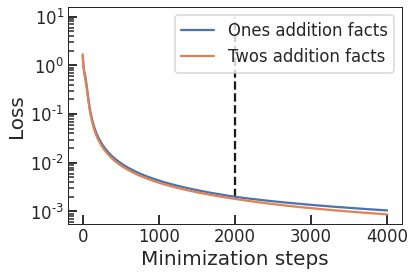

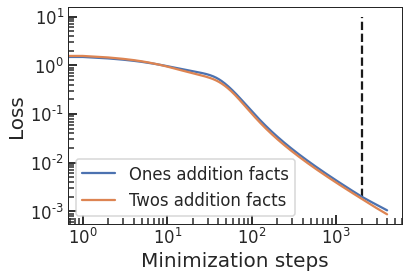

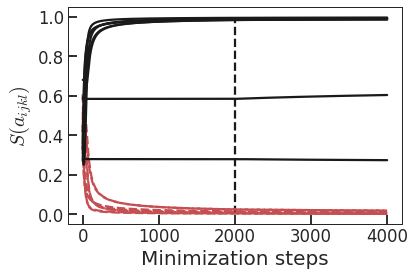

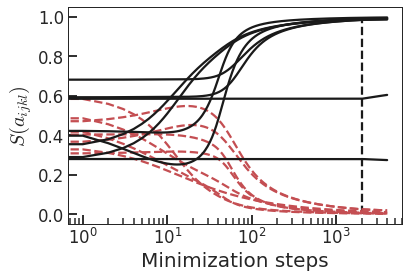

In [7]:

plt.figure()
plt.plot(losses_ones, label='Ones addition facts')
plt.plot(losses_twos, label='Twos addition facts')
plt.vlines(total_time_per_group, 2e-3, 1e1, colors='k', linestyles='--')
plt.xlabel('Minimization steps')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(losses_ones, label='Ones addition facts')
plt.plot(losses_twos, label='Twos addition facts')
plt.vlines(total_time_per_group, 2e-3, 1e1, colors='k', linestyles='--')
plt.xlabel('Minimization steps')
plt.ylabel('Loss')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=3)
plt.show()


params_save_plot = np.array(params_save)
plt.figure()
plt.plot(sigmoid(params_save_plot[:,zeros_pos]), '--r' ,label='zeros_pos')
plt.plot(sigmoid(params_save_plot[:,ones_pos]), 'k', label='ones_pos')
plt.vlines(total_time_per_group,  0, 1e0, colors='k', linestyles='--')
plt.xlabel('Minimization steps')
plt.ylabel('$S(a_{ijkl})$')
plt.show()


params_save_plot = np.array(params_save)

fig = plt.figure()
plt.plot(sigmoid(params_save_plot[:,zeros_pos]), '--r' ,label='zeros_pos')
plt.plot(sigmoid(params_save_plot[:,ones_pos]), 'k', label='ones_pos')
plt.vlines(total_time_per_group, 0, 1e0, colors='k', linestyles='--')
plt.xlabel('Minimization steps')
plt.ylabel('$S(a_{ijkl})$')
# plt.yscale('log')
plt.xscale('log')
# plt.legend()
plt.show()



## Learning addition through training one example at a time

In [8]:

learning_rate = 1
total_time_per_numbers =  50
number_of_samples = 200
steps_print = 50

np.random.seed(0)
params = np.random.uniform(-1,1,size=16) 
params = jnp.array(params)

losses = []
errs = []
test_losses = []

params_save_2 = []

time_old = time.time()

for iii in range(number_of_samples):
    
  n1 = np.random.rand(dim)
  n1 = np.round(n1)
  n1 = n1.astype(int)

  n2 = np.random.rand(dim)
  n2 = np.round(n2)
  n2 = n2.astype(int)


  for t in range(total_time_per_numbers):
    
    result = loss(params,n1,n2)
    n4 = NN_bin_sum(params,n1,n2)
    err = (bin_to_dec(n4)-bin_to_dec(correct_bin_sum(n1,n2)))/bin_to_dec(correct_bin_sum(n1,n2))
    test_loss_i = test_loss(params,test_dataset_1,test_dataset_2)

    losses += [result]
    errs += [err]
    test_losses += [test_loss_i]
    params_save_2 += [params]

    if t%steps_print==0 :

      time_new = time.time()
      print('\n', 'example', iii,  'loss', result, 'err', err, 'time', time_new-time_old)
      time_old = time_new
      print(bin_to_dec(n1),'+',bin_to_dec(n2),'=',bin_to_dec(n4))
      print('correct_bin_sum(n1,n2)',bin_to_dec(correct_bin_sum(n1,n2)),'\n')

      if plotting_intermediate_figures:

        plt.figure()
        plt.plot(losses, label='Loss')
        plt.plot(test_losses, label='Test loss')
        plt.xlabel('minimization steps')
        plt.ylabel('loss')
        plt.yscale('log')
        plt.legend()#(loc='upper center', shadow=True, fontsize='x-large')
        plt.show()

        plt.figure()
        plt.plot(losses, label='Loss')
        plt.plot(test_losses, label='Test loss')
        plt.xlabel('minimization steps')
        plt.ylabel('loss')
        plt.yscale('log')
        plt.xscale('log')
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(np.abs(errs))
        plt.xlabel('minimization steps')
        plt.ylabel('relative error')
        plt.yscale('log')
        plt.show()


        params_save_plot = np.array(params_save_2)
        plt.figure()
        plt.plot(sigmoid(params_save_plot[:,zeros_pos]), '--r' ,label='zeros_pos')
        plt.plot(sigmoid(params_save_plot[:,ones_pos]), 'k', label='ones_pos')
        plt.xlabel('Minimization steps')
        plt.ylabel('Value')
        plt.show()

    g = grad(loss)(params, n1, n2)
    params = params - learning_rate*g




 example 0 loss 1.7422304 err -0.07922045 time 89.28267931938171
15 + 21 = 33.148064
correct_bin_sum(n1,n2) 36.0 


 example 1 loss 1.3623201 err 0.048636694 time 32.53637409210205
12 + 21 = 34.60501
correct_bin_sum(n1,n2) 33.0 


 example 2 loss 0.7610704 err -0.04716752 time 2.6668879985809326
30 + 11 = 39.06613
correct_bin_sum(n1,n2) 41.0 


 example 3 loss 1.2802435 err 1.0299937 time 2.645763874053955
1 + 8 = 18.269943
correct_bin_sum(n1,n2) 9.0 


 example 4 loss 0.9697418 err 1.0796503 time 2.637446165084839
16 + 8 = 49.911606
correct_bin_sum(n1,n2) 24.0 


 example 5 loss 0.28971654 err -0.0548148 time 2.658973217010498
21 + 14 = 33.081482
correct_bin_sum(n1,n2) 35.0 


 example 6 loss 0.010342467 err 0.21277127 time 2.6270830631256104
0 + 6 = 7.2766275
correct_bin_sum(n1,n2) 6.0 


 example 7 loss 0.92348236 err -0.19171923 time 2.63846755027771
22 + 20 = 33.947792
correct_bin_sum(n1,n2) 42.0 


 example 8 loss 0.03578569 err -0.022988038 time 2.6307287216186523
21 + 13 = 33.

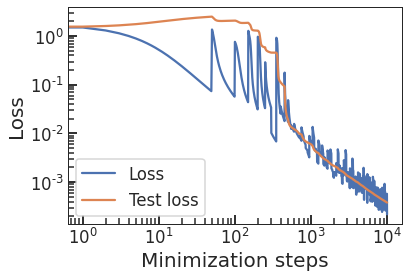

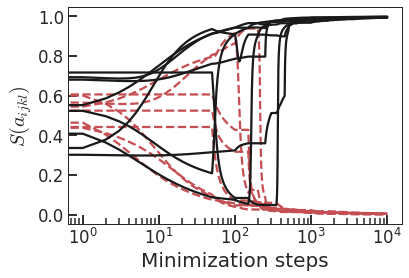

In [9]:

fig = plt.figure()
plt.plot(losses, label='Loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Minimization steps')
plt.ylabel('Loss')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=3)
plt.show()



params_save_plot = np.array(params_save_2)
fig = plt.figure()
plt.plot(sigmoid(params_save_plot[:,zeros_pos]), '--r' ,label='zeros_pos')
plt.plot(sigmoid(params_save_plot[:,ones_pos]), 'k', label='ones_pos')
plt.xlabel('Minimization steps')
plt.ylabel('$S(a_{ijkl})$')
plt.xscale('log')
plt.show()